In [ ]:
#!pip install xgboost

# XGBoost

[[XGB Document](https://xgboost.readthedocs.io/en/stable/index.html)]
- Extreme Gradient Boosting의 약자
- 베이스모델로 의사결정나무를 사용하는 GBM 기반의 머신러닝 알고리즘
- GBM과 동일하게 이전라운드에서의 예측오류를 다음 라운드의 모델 학습에 반영시킨다.
- 하지만 GBM과 달리 학습을 위한 목적함수에 트리 규제항(Regularization Term) $Ω(ℎ)$이 추가됨  
- 병렬 학습이 가능하여 GBM에 비해 학습시간이 빠르며, 규제항으로 인하여 과적합이 발생할 가능성이 더 낮다는 장점      

- 규제항 $Ω(ℎ)$은 트리의 복잡성에 패널티를 부여하는 항. 과적합 방지
    - ①번 항은 트리가 커짐에 따라 패널티 부여
    - ②번 항은 특정 끝노드에서의 출력값이 커지는 것에 대한 패널티
- 𝛾는 하이퍼파라미터로 트리의 복잡도에 대한 패널티를 의미한다. 값을 크게 할 수록 더욱 많은 가지치기가 수행됨.

### 1. 데이터 로드 및 전처리

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib

# #한글꺠짐 방지
# matplotlib.rcParams['font.family'] ='Malgun Gothic'
# matplotlib.rcParams['axes.unicode_minus'] =False

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 로드
URL = "/content/drive/MyDrive/SIL/WORK/DSS 머신러닝2/" # 데이터 위치 설정
data = pd.read_csv(URL+"data/class_balance.csv",encoding="EUC-KR")

In [ ]:
# data=pd.read_csv("./data/class_balance.csv",encoding="EUC-KR")

In [ ]:
data

X1        X2        X3        X4        X5        X6        X7  \
0    0.457896  0.530189  0.276976  0.359864  0.193059  0.322190  0.706897   
1    0.607100  0.341478  0.518992  0.395300  0.042071  0.469654  0.750000   
2    0.360781  0.369653  0.341039  0.021697  0.181737  0.528684  0.491379   
3    0.460910  0.413500  0.535685  0.302794  0.242326  0.408966  0.646552   
4    0.263068  0.279821  0.535685  0.302794  0.242326  0.408966  0.646552   
..        ...       ...       ...       ...       ...       ...       ...   
249  0.360022  0.396033  0.382803  0.070771  0.143308  0.920884  0.586207   
250  0.508628  0.437628  0.192378  0.061866  0.168425  0.481919  0.715517   
251  0.275930  0.364365  0.302236  0.376615  0.485135  0.627270  0.594828   
252  0.785179  0.271804  0.400189  0.457851  0.229526  0.244320  0.396552   
253  0.164343  0.571191  0.324472  0.401357  0.249864  0.229873  0.448276   

           X8        X9       X10  ...      X466      X467      X468  \
0    0.553781  0.653894  0.375204  ...  0.246376  0.711806  0.008532   
1    0.542031  0.447466  0.189233  ...  0.523785  0.760417  0.030930   
2    0.516722  0.300371  0.376835  ...  0.185769  0.659722  0.005333   
3    0.561615  0.415328  0.313214  ...  0.246376  0.000000  1.000000   
4    0.638747  0.660074  0.520392  ...  0.110711  0.517361  0.023677   
..        ...       ...       ...  ...       ...       ...       ...   
249  0.636336  0.337454  0.432300  ...  0.000000  0.597222  0.016212   
250  0.270563  0.407911  0.336052  ...  0.132582  0.975694  0.017065   
251  0.435673  0.420272  0.367047  ...  0.246376  0.586806  0.008532   
252  0.875565  0.110012  0.337684  ...  0.221768  0.767361  0.024317   
253  0.592648  0.498146  0.340946  ...  0.214622  0.621528  0.020904   

         X469      X470      X471      X472      X473      X474  Y  
0    0.013672  0.008467  0.402240  0.238811  0.274876  0.210238 -1  
1    0.033203  0.029759  0.210356  0.309339  0.328358  0.439175 -1  
2    0.003906  0.005311  0.381877  0.208171  0.208955  0.155761 -1  
3    1.000000  1.000000  0.381877  0.208171  0.208955  0.155761 -1  
4    0.022461  0.023447  0.608414  0.212062  0.268657  0.092827 -1  
..        ...       ...       ...       ...       ...       ... ..  
249  0.013672  0.015997  0.045307  0.147860  0.171642  0.000000  1  
250  0.015625  0.016114  0.543689  0.227626  0.320896  0.111165  1  
251  0.015625  0.008613  0.343042  0.151751  0.164179  0.143012  1  
252  0.019531  0.023461  0.509709  0.398833  0.440299  0.185945  1  
253  0.018555  0.020352  0.309061  0.178988  0.201493  0.179953  1  

[254 rows x 475 columns]

In [ ]:
data['Y'] = data['Y'].map(lambda x: 0 if x == -1 else 1) # 기존 -1, 1이었던 Y값을 모델 학습을 위해 0, 1로 변경

In [ ]:
# X, Y 분할
Y=data["Y"].copy()
X=data.drop("Y",axis=1)
X.head(3)

# X
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=22,shuffle =True)

[[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)]  
**sklearn.model_selection.train_test_split**
- **test_size** : float or int, default = 0.25, 정수값일시 test사이즈로 설정하고 싶은 샘플 수 입력
- **train_size** : float or int, default = None
- **random_state** : int, default = None, 랜덤 seed값 설정, 같은 seed 내에선 동일결과 추출
- **shuffle** : bool, default = True, 데이터셋 무작위 추출, 시계열 데이터와 같이 순차적 추출이 필요한 경우엔 Shuffle = False!
- **stratify** : array-like, default = None, True일시 계층적 샘플링 진행 ([참고](https://www.investopedia.com/terms/stratified_random_sampling.asp))

### 2. 평가 지표 함수

![Confusion Matrix](https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg)

###### 이미지 출처 : https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html

In [ ]:
# 평가 지표 출력 함수
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix

def print_all_reg(Y_test,pred):
    # Specificity를 구하기 위해 confusion matrix를 이용
    cm1 = confusion_matrix(Y_test,pred)
    specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])

    #결과 검사
    #recall = cm1[1,1]/(cm1[1,1]+cm1[1,0])
    #pre = cm1[1,1]/(cm1[1,1]+cm1[0,1])

    G_mean = recall_score(Y_test,pred) * specificity1

    print("model의 recall 값은 {:.3f}".format(recall_score(Y_test,pred)))
    print("model의 2종 오류 확률 값은 {:.3f}".format(1-recall_score(Y_test,pred)))
    print("model의 Specificity 값은 {:.3f}".format(specificity1))
    print("model의 1종 오류 확률 값은 {:.3f}".format(1-specificity1))
    print("model의 precision 값은 {:.3f}".format(precision_score(Y_test,pred)))
    print("model의 f1_score 값은 {:.3f}".format(f1_score(Y_test,pred)))
    print("model의 G-mean 값은 {:.3f}".format(np.sqrt(G_mean)))
    print("model의 accuracy 값은 {:.3f}".format(accuracy_score(Y_test,pred)))


### 3. 모델 학습 및 예측

[[XGB Parameters](https://xgboost.readthedocs.io/en/stable/parameter.html)]
### **General Parameters**
- **booster** [default= gbtree ] : 어떤 부스터 구조를 쓸지 결정한다. 의사결정기반모형(gbtree), 선형모형(gblinear), dart가 있다.
- **verbosity** [default=1] : 유효한 값은 0 (무음), 1 (경고), 2 (정보), 3 (디버그)
- **nthread** [default=사용가능한 최대수] : 학습에 사용할 CPU thread 개수로, 자동적으로 컴퓨팅 가능한 최대값을 사용
- **silent** [deafault=1] : 결과메시지 출력 여부 설정, 1일시 메시지가 나타나지 않음.
### **Booster Parameters**
- **n_estimators** [default=100] : 베이스모델인 트리 개수
- **eta** [alias = learning_rate, default=0.3] : learning rate와 동일하며, 0~1사이 값을 지정한다. 클수록 과적합 가능성 증대, 작을수록 학습 소요시간 증가
- **gamma** [alias: min_split_loss, deafult=0] : leaf node에서 추가분할 여부를 결정할 최소손실 감소값이며, 해당 값보다 손실이 크게 감소할 때 트리 추가 분할. 값이 클수록 과적합이 감소된다.
- **max_depth** [default=6] : 최대 트리 깊이, 일반적으로 3~10의 값으로 설정, 0 지정시 트리 깊이의 제한이 없음, 과대적합에 가장 큰 영향을 주는 중요 하이퍼 파라미터.
- **lambda** [alias=reg_lambda, default=1] : l2 regularization(Ridge) 적용값으로, 값이 커질수록 과적합이 감소하는 효과. -- noise나 outlier 같은 값들을 제한해줌
- **alpha** [alias=reg_alpha, default=0] : l1 regularization(Lasso) 적용값, 절대값 규제항으로 불필요한 가중치를 0으로 만드는 효과, 값이 커질수록 과적합이 감소. -- sparse feature 가 있거나 feature수가 지나치게 많을 때 효과적dla
- **colsample_bytree** [default=1] : 각 트리마다 feature 샘플링 비율, 일반적으로 0.5~1사이 값 사용
- **min_child_weight** [default=1] : leaf node에 포함되는 최소 샘플수. 값이 커질수록 과소적합, 작을수록 과대적합 발생위험
### **Train Parameters**
- **objective** [default=reg:linear] : 목적함수 설정, 해당 함수 값을 최소화 하는 방향으로 학습.
    - {회귀 : 'reg:linear', 이진분류 : 'binary:logistic', 다중분류(클래스반환) :'multi:softmax', 다중분류(확률반환) : 'multi:softprob'}
- **eval_metric** [default : 회귀=rmse, 분류=error] : 모델 검증에 사용되는 함수 설정, {'rmse', 'mae', 'logloss', 'error', 'merror', 'mlogloss', 'auc' 등}

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7,shuffle =True)

# 0.4 0.7, 0.8

### 4. GAMMA에 따른 변화

In [ ]:
from xgboost import XGBRegressor
from xgboost import XGBClassifier
eval_set = [(X_test, Y_test)] # 검증용 데이터셋 정의

gamma_list = list(np.arange(0,50,2)) # 0부터 98까지 2간격으로 출력하여 리스트 형태로 반환
#gamma_list = [0.1,0.5,0.9]

train_scores =[]
test_scores =[]

for gamma in gamma_list: # 모든 감마값에 대하여 모델 적합, 최적의 감마값 도출

    clf = XGBClassifier(use_label_encoder = False,
                        n_estimators = 100,
                        learning_rate = 0.4,
                        min_child_weight = 10,
                        colsample_bytree = 0.5,
                        max_depth = 8 , gamma = gamma, reg_lambda = 0.8,eval_metric='logloss')

    clf.fit(X_train,Y_train,eval_set = eval_set,early_stopping_rounds = 20) # eval_metric 결과가 20회동안 개선되지 않으면 조기종료

    preds_train = clf.predict(X_train) # 훈련데이터로 y값 예측
    preds = clf.predict(X_test) # 테스트 데이터로 y값 예측

    train_scores.append(f1_score(Y_train,preds_train)) # 훈련성능 저장
    test_scores.append(f1_score(Y_test,preds)) # 테스트 성능 저장



[0]	validation_0-logloss:0.58532
[1]	validation_0-logloss:0.51654
[2]	validation_0-logloss:0.45608
[3]	validation_0-logloss:0.45481


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-logloss:0.43866
[5]	validation_0-logloss:0.42413
[6]	validation_0-logloss:0.41513
[7]	validation_0-logloss:0.39534
[8]	validation_0-logloss:0.38041
[9]	validation_0-logloss:0.36392
[10]	validation_0-logloss:0.35332
[11]	validation_0-logloss:0.35874
[12]	validation_0-logloss:0.35661
[13]	validation_0-logloss:0.35172
[14]	validation_0-logloss:0.34863
[15]	validation_0-logloss:0.34506
[16]	validation_0-logloss:0.32780
[17]	validation_0-logloss:0.33090
[18]	validation_0-logloss:0.32867
[19]	validation_0-logloss:0.32430
[20]	validation_0-logloss:0.32875
[21]	validation_0-logloss:0.32434
[22]	validation_0-logloss:0.31791
[23]	validation_0-logloss:0.31136
[24]	validation_0-logloss:0.31221
[25]	validation_0-logloss:0.31931
[26]	validation_0-logloss:0.32675
[27]	validation_0-logloss:0.33042
[28]	validation_0-logloss:0.32844
[29]	validation_0-logloss:0.33304
[30]	validation_0-logloss:0.32847
[31]	validation_0-logloss:0.32865
[32]	validation_0-logloss:0.32975
[33]	validation_0-lo

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.42413
[6]	validation_0-logloss:0.41513
[7]	validation_0-logloss:0.39534
[8]	validation_0-logloss:0.38041
[9]	validation_0-logloss:0.36392
[10]	validation_0-logloss:0.35332
[11]	validation_0-logloss:0.35874
[12]	validation_0-logloss:0.35661
[13]	validation_0-logloss:0.35172
[14]	validation_0-logloss:0.34863
[15]	validation_0-logloss:0.34506
[16]	validation_0-logloss:0.32780
[17]	validation_0-logloss:0.33090
[18]	validation_0-logloss:0.32867
[19]	validation_0-logloss:0.32430
[20]	validation_0-logloss:0.32875
[21]	validation_0-logloss:0.32434
[22]	validation_0-logloss:0.31791
[23]	validation_0-logloss:0.31136
[24]	validation_0-logloss:0.31221
[25]	validation_0-logloss:0.31931
[26]	validation_0-logloss:0.32675
[27]	validation_0-logloss:0.32671
[28]	validation_0-logloss:0.32669
[29]	validation_0-logloss:0.32668
[30]	validation_0-logloss:0.32667
[31]	validation_0-logloss:0.32667
[32]	validation_0-logloss:0.32666
[33]	validation_0-logloss:0.32666
[34]	validation_0-l

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-logloss:0.43866
[5]	validation_0-logloss:0.42413
[6]	validation_0-logloss:0.41513
[7]	validation_0-logloss:0.39534
[8]	validation_0-logloss:0.38041
[9]	validation_0-logloss:0.36392
[10]	validation_0-logloss:0.35332
[11]	validation_0-logloss:0.35874
[12]	validation_0-logloss:0.35661
[13]	validation_0-logloss:0.35659
[14]	validation_0-logloss:0.35657
[15]	validation_0-logloss:0.35656
[16]	validation_0-logloss:0.35655
[17]	validation_0-logloss:0.35655
[18]	validation_0-logloss:0.35655
[19]	validation_0-logloss:0.35655
[20]	validation_0-logloss:0.35654
[21]	validation_0-logloss:0.35654
[22]	validation_0-logloss:0.35654
[23]	validation_0-logloss:0.35654
[24]	validation_0-logloss:0.35654
[25]	validation_0-logloss:0.35654
[26]	validation_0-logloss:0.35654
[27]	validation_0-logloss:0.35654
[28]	validation_0-logloss:0.35654
[29]	validation_0-logloss:0.35654
[30]	validation_0-logloss:0.35654
[0]	validation_0-logloss:0.56184
[1]	validation_0-logloss:0.49953
[2]	validation_0-loglo

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.40153
[6]	validation_0-logloss:0.38054
[7]	validation_0-logloss:0.38044
[8]	validation_0-logloss:0.36749
[9]	validation_0-logloss:0.34846
[10]	validation_0-logloss:0.34847
[11]	validation_0-logloss:0.34848
[12]	validation_0-logloss:0.34848
[13]	validation_0-logloss:0.34849
[14]	validation_0-logloss:0.34849
[15]	validation_0-logloss:0.34849
[16]	validation_0-logloss:0.34849
[17]	validation_0-logloss:0.34849
[18]	validation_0-logloss:0.34849
[19]	validation_0-logloss:0.34849
[20]	validation_0-logloss:0.34849
[21]	validation_0-logloss:0.34849
[22]	validation_0-logloss:0.34849
[23]	validation_0-logloss:0.34849
[24]	validation_0-logloss:0.34849
[25]	validation_0-logloss:0.34849
[26]	validation_0-logloss:0.34849
[27]	validation_0-logloss:0.34849
[28]	validation_0-logloss:0.34849
[29]	validation_0-logloss:0.34849
[0]	validation_0-logloss:0.56184
[1]	validation_0-logloss:0.49953
[2]	validation_0-logloss:0.44246
[3]	validation_0-logloss:0.42843
[4]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.39830
[6]	validation_0-logloss:0.39834
[7]	validation_0-logloss:0.39836
[8]	validation_0-logloss:0.39837
[9]	validation_0-logloss:0.35959
[10]	validation_0-logloss:0.35955
[11]	validation_0-logloss:0.35953
[12]	validation_0-logloss:0.35952
[13]	validation_0-logloss:0.35951
[14]	validation_0-logloss:0.35951
[15]	validation_0-logloss:0.35951
[16]	validation_0-logloss:0.35950
[17]	validation_0-logloss:0.35950
[18]	validation_0-logloss:0.35950
[19]	validation_0-logloss:0.35950
[20]	validation_0-logloss:0.35950
[21]	validation_0-logloss:0.35950
[22]	validation_0-logloss:0.35950
[23]	validation_0-logloss:0.35950
[24]	validation_0-logloss:0.35950
[25]	validation_0-logloss:0.35950
[26]	validation_0-logloss:0.35950
[27]	validation_0-logloss:0.35950
[28]	validation_0-logloss:0.35950
[29]	validation_0-logloss:0.35950
[30]	validation_0-logloss:0.35950
[31]	validation_0-logloss:0.35950
[32]	validation_0-logloss:0.35950
[33]	validation_0-logloss:0.35950
[34]	validation_0-l

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-logloss:0.42452
[5]	validation_0-logloss:0.40931
[6]	validation_0-logloss:0.40941
[7]	validation_0-logloss:0.40946
[8]	validation_0-logloss:0.40950
[9]	validation_0-logloss:0.38440
[10]	validation_0-logloss:0.38449
[11]	validation_0-logloss:0.38455
[12]	validation_0-logloss:0.38459
[13]	validation_0-logloss:0.38461
[14]	validation_0-logloss:0.38463
[15]	validation_0-logloss:0.38463
[16]	validation_0-logloss:0.38464
[17]	validation_0-logloss:0.38464
[18]	validation_0-logloss:0.38464
[19]	validation_0-logloss:0.38464
[20]	validation_0-logloss:0.38465
[21]	validation_0-logloss:0.38465
[22]	validation_0-logloss:0.38465
[23]	validation_0-logloss:0.38465
[24]	validation_0-logloss:0.38465
[25]	validation_0-logloss:0.38465
[26]	validation_0-logloss:0.38465
[27]	validation_0-logloss:0.38465
[28]	validation_0-logloss:0.38465
[29]	validation_0-logloss:0.38465


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.56184
[1]	validation_0-logloss:0.49953
[2]	validation_0-logloss:0.44246
[3]	validation_0-logloss:0.44222
[4]	validation_0-logloss:0.42396
[5]	validation_0-logloss:0.40732
[6]	validation_0-logloss:0.40738
[7]	validation_0-logloss:0.40742
[8]	validation_0-logloss:0.40745
[9]	validation_0-logloss:0.40746
[10]	validation_0-logloss:0.40747
[11]	validation_0-logloss:0.40748
[12]	validation_0-logloss:0.40748
[13]	validation_0-logloss:0.40748
[14]	validation_0-logloss:0.40748
[15]	validation_0-logloss:0.40748
[16]	validation_0-logloss:0.40749
[17]	validation_0-logloss:0.40749
[18]	validation_0-logloss:0.40749
[19]	validation_0-logloss:0.40749
[20]	validation_0-logloss:0.40749
[21]	validation_0-logloss:0.40749
[22]	validation_0-logloss:0.40749
[23]	validation_0-logloss:0.40749
[24]	validation_0-logloss:0.40749
[25]	validation_0-logloss:0.40749


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.56184
[1]	validation_0-logloss:0.53028
[2]	validation_0-logloss:0.46251
[3]	validation_0-logloss:0.46239
[4]	validation_0-logloss:0.44357
[5]	validation_0-logloss:0.44355
[6]	validation_0-logloss:0.44353
[7]	validation_0-logloss:0.44352
[8]	validation_0-logloss:0.44351
[9]	validation_0-logloss:0.44351
[10]	validation_0-logloss:0.44351
[11]	validation_0-logloss:0.44351
[12]	validation_0-logloss:0.44351
[13]	validation_0-logloss:0.44351
[14]	validation_0-logloss:0.44351
[15]	validation_0-logloss:0.44351
[16]	validation_0-logloss:0.44351
[17]	validation_0-logloss:0.44351
[18]	validation_0-logloss:0.44351
[19]	validation_0-logloss:0.44351
[20]	validation_0-logloss:0.44351
[21]	validation_0-logloss:0.44351
[22]	validation_0-logloss:0.44351
[23]	validation_0-logloss:0.44351
[24]	validation_0-logloss:0.44351
[25]	validation_0-logloss:0.44351
[26]	validation_0-logloss:0.44351
[27]	validation_0-logloss:0.44351
[28]	validation_0-logloss:0.44351
[29]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.56184
[1]	validation_0-logloss:0.53028
[2]	validation_0-logloss:0.46251
[3]	validation_0-logloss:0.46239
[4]	validation_0-logloss:0.44357
[5]	validation_0-logloss:0.44355
[6]	validation_0-logloss:0.44353
[7]	validation_0-logloss:0.44352
[8]	validation_0-logloss:0.44351
[9]	validation_0-logloss:0.44351
[10]	validation_0-logloss:0.44351
[11]	validation_0-logloss:0.44351
[12]	validation_0-logloss:0.44351
[13]	validation_0-logloss:0.44351
[14]	validation_0-logloss:0.44351
[15]	validation_0-logloss:0.44351
[16]	validation_0-logloss:0.44351
[17]	validation_0-logloss:0.44351
[18]	validation_0-logloss:0.44351
[19]	validation_0-logloss:0.44351
[20]	validation_0-logloss:0.44351
[21]	validation_0-logloss:0.44351
[22]	validation_0-logloss:0.44351
[23]	validation_0-logloss:0.44351
[24]	validation_0-logloss:0.44351
[25]	validation_0-logloss:0.44351
[26]	validation_0-logloss:0.44351
[27]	validation_0-logloss:0.44351
[28]	validation_0-logloss:0.44351
[29]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-logloss:0.48648
[4]	validation_0-logloss:0.46513
[5]	validation_0-logloss:0.46504
[6]	validation_0-logloss:0.46499
[7]	validation_0-logloss:0.46496
[8]	validation_0-logloss:0.46494
[9]	validation_0-logloss:0.46493
[10]	validation_0-logloss:0.46492
[11]	validation_0-logloss:0.46491
[12]	validation_0-logloss:0.46491
[13]	validation_0-logloss:0.46491
[14]	validation_0-logloss:0.46491
[15]	validation_0-logloss:0.46491
[16]	validation_0-logloss:0.46491
[17]	validation_0-logloss:0.46491
[18]	validation_0-logloss:0.46491
[19]	validation_0-logloss:0.46491
[20]	validation_0-logloss:0.46491
[21]	validation_0-logloss:0.46491
[22]	validation_0-logloss:0.46491
[23]	validation_0-logloss:0.46491
[24]	validation_0-logloss:0.46491
[25]	validation_0-logloss:0.46491
[26]	validation_0-logloss:0.46491
[27]	validation_0-logloss:0.46491
[28]	validation_0-logloss:0.46491
[29]	validation_0-logloss:0.46491
[30]	validation_0-logloss:0.46491
[31]	validation_0-logloss:0.46491
[32]	validation_0-log

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.48619
[7]	validation_0-logloss:0.48615
[8]	validation_0-logloss:0.48613
[9]	validation_0-logloss:0.48612
[10]	validation_0-logloss:0.48611
[11]	validation_0-logloss:0.48611
[12]	validation_0-logloss:0.48611
[13]	validation_0-logloss:0.48611
[14]	validation_0-logloss:0.48611
[15]	validation_0-logloss:0.48610
[16]	validation_0-logloss:0.48610
[17]	validation_0-logloss:0.48610
[18]	validation_0-logloss:0.48610
[19]	validation_0-logloss:0.48610
[20]	validation_0-logloss:0.48610
[21]	validation_0-logloss:0.48610
[22]	validation_0-logloss:0.48610
[23]	validation_0-logloss:0.48610
[24]	validation_0-logloss:0.48610
[25]	validation_0-logloss:0.48610
[26]	validation_0-logloss:0.48610
[27]	validation_0-logloss:0.48610
[28]	validation_0-logloss:0.48610
[29]	validation_0-logloss:0.48610
[30]	validation_0-logloss:0.48610
[31]	validation_0-logloss:0.48610
[32]	validation_0-logloss:0.48610
[33]	validation_0-logloss:0.48610
[34]	validation_0-logloss:0.48610
[35]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.50834
[7]	validation_0-logloss:0.50831
[8]	validation_0-logloss:0.50829
[9]	validation_0-logloss:0.50828
[10]	validation_0-logloss:0.50827
[11]	validation_0-logloss:0.50827
[12]	validation_0-logloss:0.50826
[13]	validation_0-logloss:0.50826
[14]	validation_0-logloss:0.50826
[15]	validation_0-logloss:0.50826
[16]	validation_0-logloss:0.50826
[17]	validation_0-logloss:0.50826
[18]	validation_0-logloss:0.50826
[19]	validation_0-logloss:0.50826
[20]	validation_0-logloss:0.50826
[21]	validation_0-logloss:0.50826
[22]	validation_0-logloss:0.50826
[23]	validation_0-logloss:0.50826
[24]	validation_0-logloss:0.50826
[25]	validation_0-logloss:0.50826
[26]	validation_0-logloss:0.50826
[27]	validation_0-logloss:0.50826
[28]	validation_0-logloss:0.50826
[29]	validation_0-logloss:0.50826
[30]	validation_0-logloss:0.50826
[31]	validation_0-logloss:0.50826
[32]	validation_0-logloss:0.50826
[33]	validation_0-logloss:0.50826
[34]	validation_0-logloss:0.50826
[35]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.50834
[7]	validation_0-logloss:0.50831
[8]	validation_0-logloss:0.50829
[9]	validation_0-logloss:0.50828
[10]	validation_0-logloss:0.50827
[11]	validation_0-logloss:0.50827
[12]	validation_0-logloss:0.50826
[13]	validation_0-logloss:0.50826
[14]	validation_0-logloss:0.50826
[15]	validation_0-logloss:0.50826
[16]	validation_0-logloss:0.50826
[17]	validation_0-logloss:0.50826
[18]	validation_0-logloss:0.50826
[19]	validation_0-logloss:0.50826
[20]	validation_0-logloss:0.50826
[21]	validation_0-logloss:0.50826
[22]	validation_0-logloss:0.50826
[23]	validation_0-logloss:0.50826
[24]	validation_0-logloss:0.50826
[25]	validation_0-logloss:0.50826
[26]	validation_0-logloss:0.50826
[27]	validation_0-logloss:0.50826
[28]	validation_0-logloss:0.50826
[29]	validation_0-logloss:0.50826
[30]	validation_0-logloss:0.50826
[31]	validation_0-logloss:0.50826
[32]	validation_0-logloss:0.50826
[33]	validation_0-logloss:0.50826
[34]	validation_0-logloss:0.50826
[35]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-logloss:0.50849
[5]	validation_0-logloss:0.50840
[6]	validation_0-logloss:0.50834
[7]	validation_0-logloss:0.50831
[8]	validation_0-logloss:0.50829
[9]	validation_0-logloss:0.50828
[10]	validation_0-logloss:0.50827
[11]	validation_0-logloss:0.50827
[12]	validation_0-logloss:0.50826
[13]	validation_0-logloss:0.50826
[14]	validation_0-logloss:0.50826
[15]	validation_0-logloss:0.50826
[16]	validation_0-logloss:0.50826
[17]	validation_0-logloss:0.50826
[18]	validation_0-logloss:0.50826
[19]	validation_0-logloss:0.50826
[20]	validation_0-logloss:0.50826
[21]	validation_0-logloss:0.50826
[22]	validation_0-logloss:0.50826
[23]	validation_0-logloss:0.50826
[24]	validation_0-logloss:0.50826
[25]	validation_0-logloss:0.50826
[26]	validation_0-logloss:0.50826
[27]	validation_0-logloss:0.50826
[28]	validation_0-logloss:0.50826
[29]	validation_0-logloss:0.50826
[30]	validation_0-logloss:0.50826
[31]	validation_0-logloss:0.50826
[32]	validation_0-logloss:0.50826
[33]	validation_0-lo

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.50834
[7]	validation_0-logloss:0.50831
[8]	validation_0-logloss:0.50829
[9]	validation_0-logloss:0.50828
[10]	validation_0-logloss:0.50827
[11]	validation_0-logloss:0.50827
[12]	validation_0-logloss:0.50826
[13]	validation_0-logloss:0.50826
[14]	validation_0-logloss:0.50826
[15]	validation_0-logloss:0.50826
[16]	validation_0-logloss:0.50826
[17]	validation_0-logloss:0.50826
[18]	validation_0-logloss:0.50826
[19]	validation_0-logloss:0.50826
[20]	validation_0-logloss:0.50826
[21]	validation_0-logloss:0.50826
[22]	validation_0-logloss:0.50826
[23]	validation_0-logloss:0.50826
[24]	validation_0-logloss:0.50826
[25]	validation_0-logloss:0.50826
[26]	validation_0-logloss:0.50826
[27]	validation_0-logloss:0.50826
[28]	validation_0-logloss:0.50826
[29]	validation_0-logloss:0.50826
[30]	validation_0-logloss:0.50826
[31]	validation_0-logloss:0.50826
[32]	validation_0-logloss:0.50826
[33]	validation_0-logloss:0.50826
[34]	validation_0-logloss:0.50826
[35]	validation_0-

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.55926
[2]	validation_0-logloss:0.50889
[3]	validation_0-logloss:0.50864
[4]	validation_0-logloss:0.50849
[5]	validation_0-logloss:0.50840
[6]	validation_0-logloss:0.50834
[7]	validation_0-logloss:0.50831
[8]	validation_0-logloss:0.50829
[9]	validation_0-logloss:0.50828
[10]	validation_0-logloss:0.50827
[11]	validation_0-logloss:0.50827
[12]	validation_0-logloss:0.50826
[13]	validation_0-logloss:0.50826
[14]	validation_0-logloss:0.50826
[15]	validation_0-logloss:0.50826
[16]	validation_0-logloss:0.50826
[17]	validation_0-logloss:0.50826
[18]	validation_0-logloss:0.50826
[19]	validation_0-logloss:0.50826
[20]	validation_0-logloss:0.50826
[21]	validation_0-logloss:0.50826
[22]	validation_0-logloss:0.50826
[23]	validation_0-logloss:0.50826
[24]	validation_0-logloss:0.50826
[25]	validation_0-logloss:0.50826
[26]	validation_0-logloss:0.50826
[27]	validation_0-logloss:0.50826
[28]	validation_0-logloss:0.50826
[29]	validation_0-logloss:0.50826
[30]	validation_0-loglo

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.55949
[7]	validation_0-logloss:0.55949
[8]	validation_0-logloss:0.55950
[9]	validation_0-logloss:0.55950
[10]	validation_0-logloss:0.55950
[11]	validation_0-logloss:0.55950
[12]	validation_0-logloss:0.55951
[13]	validation_0-logloss:0.55951
[14]	validation_0-logloss:0.55951
[15]	validation_0-logloss:0.55951
[16]	validation_0-logloss:0.55951
[17]	validation_0-logloss:0.55951
[18]	validation_0-logloss:0.55951
[19]	validation_0-logloss:0.55951
[20]	validation_0-logloss:0.55951
[21]	validation_0-logloss:0.55951
[0]	validation_0-logloss:0.59461
[1]	validation_0-logloss:0.55926
[2]	validation_0-logloss:0.55936
[3]	validation_0-logloss:0.55942
[4]	validation_0-logloss:0.55945


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.55947
[6]	validation_0-logloss:0.55949
[7]	validation_0-logloss:0.55949
[8]	validation_0-logloss:0.55950
[9]	validation_0-logloss:0.55950
[10]	validation_0-logloss:0.55950
[11]	validation_0-logloss:0.55950
[12]	validation_0-logloss:0.55951
[13]	validation_0-logloss:0.55951
[14]	validation_0-logloss:0.55951
[15]	validation_0-logloss:0.55951
[16]	validation_0-logloss:0.55951
[17]	validation_0-logloss:0.55951
[18]	validation_0-logloss:0.55951
[19]	validation_0-logloss:0.55951
[20]	validation_0-logloss:0.55951
[0]	validation_0-logloss:0.59461
[1]	validation_0-logloss:0.55926
[2]	validation_0-logloss:0.55936
[3]	validation_0-logloss:0.55942


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-logloss:0.55945
[5]	validation_0-logloss:0.55947
[6]	validation_0-logloss:0.55949
[7]	validation_0-logloss:0.55949
[8]	validation_0-logloss:0.55950
[9]	validation_0-logloss:0.55950
[10]	validation_0-logloss:0.55950
[11]	validation_0-logloss:0.55950
[12]	validation_0-logloss:0.55951
[13]	validation_0-logloss:0.55951
[14]	validation_0-logloss:0.55951
[15]	validation_0-logloss:0.55951
[16]	validation_0-logloss:0.55951
[17]	validation_0-logloss:0.55951
[18]	validation_0-logloss:0.55951
[19]	validation_0-logloss:0.55951
[20]	validation_0-logloss:0.55951
[0]	validation_0-logloss:0.59461
[1]	validation_0-logloss:0.55926
[2]	validation_0-logloss:0.55936
[3]	validation_0-logloss:0.55942
[4]	validation_0-logloss:0.55945
[5]	validation_0-logloss:0.55947


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.55949
[7]	validation_0-logloss:0.55949
[8]	validation_0-logloss:0.55950
[9]	validation_0-logloss:0.55950
[10]	validation_0-logloss:0.55950
[11]	validation_0-logloss:0.55950
[12]	validation_0-logloss:0.55951
[13]	validation_0-logloss:0.55951
[14]	validation_0-logloss:0.55951
[15]	validation_0-logloss:0.55951
[16]	validation_0-logloss:0.55951
[17]	validation_0-logloss:0.55951
[18]	validation_0-logloss:0.55951
[19]	validation_0-logloss:0.55951
[20]	validation_0-logloss:0.55951
[21]	validation_0-logloss:0.55951
[0]	validation_0-logloss:0.59461
[1]	validation_0-logloss:0.55926
[2]	validation_0-logloss:0.55936
[3]	validation_0-logloss:0.55942
[4]	validation_0-logloss:0.55945


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.55947
[6]	validation_0-logloss:0.55949
[7]	validation_0-logloss:0.55949
[8]	validation_0-logloss:0.55950
[9]	validation_0-logloss:0.55950
[10]	validation_0-logloss:0.55950
[11]	validation_0-logloss:0.55950
[12]	validation_0-logloss:0.55951
[13]	validation_0-logloss:0.55951
[14]	validation_0-logloss:0.55951
[15]	validation_0-logloss:0.55951
[16]	validation_0-logloss:0.55951
[17]	validation_0-logloss:0.55951
[18]	validation_0-logloss:0.55951
[19]	validation_0-logloss:0.55951
[20]	validation_0-logloss:0.55951
[21]	validation_0-logloss:0.55951
[0]	validation_0-logloss:0.59461
[1]	validation_0-logloss:0.59462
[2]	validation_0-logloss:0.59463
[3]	validation_0-logloss:0.59464
[4]	validation_0-logloss:0.59464


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.59464
[6]	validation_0-logloss:0.59464
[7]	validation_0-logloss:0.59464
[8]	validation_0-logloss:0.59464
[9]	validation_0-logloss:0.59465
[10]	validation_0-logloss:0.59465
[11]	validation_0-logloss:0.59465
[12]	validation_0-logloss:0.59465
[13]	validation_0-logloss:0.59465
[14]	validation_0-logloss:0.59465
[15]	validation_0-logloss:0.59465
[16]	validation_0-logloss:0.59465
[17]	validation_0-logloss:0.59465
[18]	validation_0-logloss:0.59465
[19]	validation_0-logloss:0.59465
[20]	validation_0-logloss:0.59465
[0]	validation_0-logloss:0.66481
[1]	validation_0-logloss:0.61936
[2]	validation_0-logloss:0.61933
[3]	validation_0-logloss:0.61932
[4]	validation_0-logloss:0.61931


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.61931
[6]	validation_0-logloss:0.61930
[7]	validation_0-logloss:0.61930
[8]	validation_0-logloss:0.61930
[9]	validation_0-logloss:0.61930
[10]	validation_0-logloss:0.61930
[11]	validation_0-logloss:0.61930
[12]	validation_0-logloss:0.61930
[13]	validation_0-logloss:0.61930
[14]	validation_0-logloss:0.61930
[15]	validation_0-logloss:0.61930
[16]	validation_0-logloss:0.61930
[17]	validation_0-logloss:0.61930
[18]	validation_0-logloss:0.61930
[19]	validation_0-logloss:0.61930
[20]	validation_0-logloss:0.61930
[21]	validation_0-logloss:0.61930
[22]	validation_0-logloss:0.61930
[23]	validation_0-logloss:0.61930
[24]	validation_0-logloss:0.61930
[25]	validation_0-logloss:0.61930
[26]	validation_0-logloss:0.61930
[27]	validation_0-logloss:0.61930
[28]	validation_0-logloss:0.61930
[29]	validation_0-logloss:0.61930
[30]	validation_0-logloss:0.61930
[31]	validation_0-logloss:0.61930
[32]	validation_0-logloss:0.61930
[33]	validation_0-logloss:0.61930
[34]	validation_0-l

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-logloss:0.61931
[5]	validation_0-logloss:0.61931
[6]	validation_0-logloss:0.61930
[7]	validation_0-logloss:0.61930
[8]	validation_0-logloss:0.61930
[9]	validation_0-logloss:0.61930
[10]	validation_0-logloss:0.61930
[11]	validation_0-logloss:0.61930
[12]	validation_0-logloss:0.61930
[13]	validation_0-logloss:0.61930
[14]	validation_0-logloss:0.61930
[15]	validation_0-logloss:0.61930
[16]	validation_0-logloss:0.61930
[17]	validation_0-logloss:0.61930
[18]	validation_0-logloss:0.61930
[19]	validation_0-logloss:0.61930
[20]	validation_0-logloss:0.61930
[21]	validation_0-logloss:0.61930
[22]	validation_0-logloss:0.61930
[23]	validation_0-logloss:0.61930
[24]	validation_0-logloss:0.61930
[25]	validation_0-logloss:0.61930
[26]	validation_0-logloss:0.61930
[27]	validation_0-logloss:0.61930
[28]	validation_0-logloss:0.61930
[29]	validation_0-logloss:0.61930
[30]	validation_0-logloss:0.61930
[31]	validation_0-logloss:0.61930
[32]	validation_0-logloss:0.61930
[33]	validation_0-lo

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.66481
[1]	validation_0-logloss:0.61936
[2]	validation_0-logloss:0.61933
[3]	validation_0-logloss:0.61932
[4]	validation_0-logloss:0.61931
[5]	validation_0-logloss:0.61931
[6]	validation_0-logloss:0.61930
[7]	validation_0-logloss:0.61930
[8]	validation_0-logloss:0.61930
[9]	validation_0-logloss:0.61930
[10]	validation_0-logloss:0.61930
[11]	validation_0-logloss:0.61930
[12]	validation_0-logloss:0.61930
[13]	validation_0-logloss:0.61930
[14]	validation_0-logloss:0.61930
[15]	validation_0-logloss:0.61930
[16]	validation_0-logloss:0.61930
[17]	validation_0-logloss:0.61930
[18]	validation_0-logloss:0.61930
[19]	validation_0-logloss:0.61930
[20]	validation_0-logloss:0.61930
[21]	validation_0-logloss:0.61930
[22]	validation_0-logloss:0.61930
[23]	validation_0-logloss:0.61930
[24]	validation_0-logloss:0.61930
[25]	validation_0-logloss:0.61930
[26]	validation_0-logloss:0.61930
[27]	validation_0-logloss:0.61930
[28]	validation_0-logloss:0.61930
[29]	validation_0-loglos

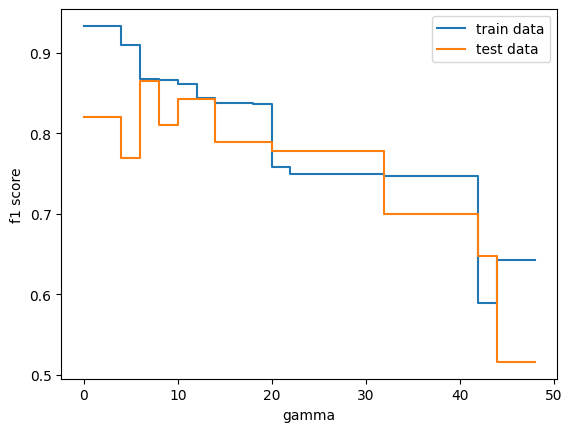

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("gamma")
ax.set_ylabel("f1 score")

ax.plot(gamma_list, train_scores,  label="train data", drawstyle="steps-post")
ax.plot(gamma_list, test_scores,  label="test data", drawstyle="steps-post")


ax.legend()
#plt.xlim(0.7)
plt.show()
plt.close('all')

In [ ]:
best_gamma = gamma_list[np.argmax(test_scores)]
print(f"최적의 gamma 값: {best_gamma}")

최적의 gamma 값: 6


- 감마값의 증가에 따라, 더 많은 가지치기가 수행되어 모델 성능이 낮아짐

### 5. LAMBDA에 따른 변화


In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20,shuffle =True)



In [ ]:

from xgboost import XGBClassifier
eval_set = [(X_test, Y_test)]

lambda_list = list(np.arange(0,10,0.5)) # 0부터 9.5까지 0.5간격으로 출력하여 리스트 형태로 반환


train_scores =[]
test_scores =[]

for alpha in lambda_list: # 모든 alpha값에 대하여 모델 적합, 최적의 람다값 도출

    clf = XGBClassifier(use_label_encoder = False,
                        n_estimators = 200,
                        learning_rate = 0.6,
                        min_child_weight = 10,
                        colsample_bytree = 0.5,
                        max_depth = 8 , gamma = 6, reg_lambda = alpha, eval_metric='logloss')

    clf.fit(X_train,Y_train,eval_set = eval_set,early_stopping_rounds = 20) # 검증용 데이터셋에서 eval_metric(=logloss) 결과가 20회동안 개선되지 않으면 조기종료

    preds_train = clf.predict(X_train) # 훈련데이터로 y값 예측
    preds = clf.predict(X_test) # 테스트데이터로 y값 예측

    train_scores.append(f1_score(Y_train,preds_train)) # 훈련성능 평가
    test_scores.append(f1_score(Y_test,preds)) # 테스트성능 평가



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.52796
[1]	validation_0-logloss:0.45538
[2]	validation_0-logloss:0.44171
[3]	validation_0-logloss:0.45881
[4]	validation_0-logloss:0.43710
[5]	validation_0-logloss:0.42021
[6]	validation_0-logloss:0.41985
[7]	validation_0-logloss:0.41971
[8]	validation_0-logloss:0.41965
[9]	validation_0-logloss:0.41963
[10]	validation_0-logloss:0.41962
[11]	validation_0-logloss:0.41961
[12]	validation_0-logloss:0.41961
[13]	validation_0-logloss:0.41961
[14]	validation_0-logloss:0.41961
[15]	validation_0-logloss:0.41961
[16]	validation_0-logloss:0.41961
[17]	validation_0-logloss:0.41961
[18]	validation_0-logloss:0.41961
[19]	validation_0-logloss:0.41961
[20]	validation_0-logloss:0.41961
[21]	validation_0-logloss:0.41961
[22]	validation_0-logloss:0.41961
[23]	validation_0-logloss:0.41961
[24]	validation_0-logloss:0.41961
[25]	validation_0-logloss:0.41961
[26]	validation_0-logloss:0.41961
[27]	validation_0-logloss:0.41961
[28]	validation_0-logloss:0.41961
[29]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.52986
[1]	validation_0-logloss:0.45751
[2]	validation_0-logloss:0.43239
[3]	validation_0-logloss:0.41481
[4]	validation_0-logloss:0.40785
[5]	validation_0-logloss:0.42318
[6]	validation_0-logloss:0.40326
[7]	validation_0-logloss:0.40305
[8]	validation_0-logloss:0.40297
[9]	validation_0-logloss:0.40294
[10]	validation_0-logloss:0.40293
[11]	validation_0-logloss:0.40292
[12]	validation_0-logloss:0.40292
[13]	validation_0-logloss:0.40292
[14]	validation_0-logloss:0.40292
[15]	validation_0-logloss:0.40292
[16]	validation_0-logloss:0.40292
[17]	validation_0-logloss:0.40292
[18]	validation_0-logloss:0.40292
[19]	validation_0-logloss:0.40292
[20]	validation_0-logloss:0.40292
[21]	validation_0-logloss:0.40292
[22]	validation_0-logloss:0.40292
[23]	validation_0-logloss:0.40292
[24]	validation_0-logloss:0.40292
[25]	validation_0-logloss:0.40292
[26]	validation_0-logloss:0.40292
[27]	validation_0-logloss:0.40292
[28]	validation_0-logloss:0.40292
[29]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.42324
[6]	validation_0-logloss:0.40344
[7]	validation_0-logloss:0.40330
[8]	validation_0-logloss:0.40324
[9]	validation_0-logloss:0.40321
[10]	validation_0-logloss:0.40320
[11]	validation_0-logloss:0.40319
[12]	validation_0-logloss:0.40319
[13]	validation_0-logloss:0.40319
[14]	validation_0-logloss:0.40319
[15]	validation_0-logloss:0.40319
[16]	validation_0-logloss:0.40319
[17]	validation_0-logloss:0.40319
[18]	validation_0-logloss:0.40319
[19]	validation_0-logloss:0.40319
[20]	validation_0-logloss:0.40319
[21]	validation_0-logloss:0.40319
[22]	validation_0-logloss:0.40319
[23]	validation_0-logloss:0.40319
[24]	validation_0-logloss:0.40319
[25]	validation_0-logloss:0.40319
[26]	validation_0-logloss:0.40319
[27]	validation_0-logloss:0.40319
[28]	validation_0-logloss:0.40319
[29]	validation_0-logloss:0.40319
[30]	validation_0-logloss:0.40319
[31]	validation_0-logloss:0.40319
[32]	validation_0-logloss:0.40319
[33]	validation_0-logloss:0.40319
[34]	validation_0-l

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.42366
[6]	validation_0-logloss:0.42376
[7]	validation_0-logloss:0.41454
[8]	validation_0-logloss:0.40090
[9]	validation_0-logloss:0.40062
[10]	validation_0-logloss:0.40050
[11]	validation_0-logloss:0.40045
[12]	validation_0-logloss:0.40043
[13]	validation_0-logloss:0.40042
[14]	validation_0-logloss:0.40042
[15]	validation_0-logloss:0.40042
[16]	validation_0-logloss:0.40042
[17]	validation_0-logloss:0.40042
[18]	validation_0-logloss:0.40041
[19]	validation_0-logloss:0.40041
[20]	validation_0-logloss:0.40041
[21]	validation_0-logloss:0.40041
[22]	validation_0-logloss:0.40041
[23]	validation_0-logloss:0.40041
[24]	validation_0-logloss:0.40041
[25]	validation_0-logloss:0.40041
[26]	validation_0-logloss:0.40041
[27]	validation_0-logloss:0.40041
[28]	validation_0-logloss:0.40041
[29]	validation_0-logloss:0.40041
[30]	validation_0-logloss:0.40041
[31]	validation_0-logloss:0.40041
[32]	validation_0-logloss:0.40041
[33]	validation_0-logloss:0.40041
[34]	validation_0-l

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.53572
[1]	validation_0-logloss:0.46440
[2]	validation_0-logloss:0.43903
[3]	validation_0-logloss:0.41561
[4]	validation_0-logloss:0.39797
[5]	validation_0-logloss:0.41409
[6]	validation_0-logloss:0.41418
[7]	validation_0-logloss:0.40396
[8]	validation_0-logloss:0.38925
[9]	validation_0-logloss:0.36570
[10]	validation_0-logloss:0.36582
[11]	validation_0-logloss:0.36587
[12]	validation_0-logloss:0.36589
[13]	validation_0-logloss:0.36590
[14]	validation_0-logloss:0.36591
[15]	validation_0-logloss:0.36591
[16]	validation_0-logloss:0.36591
[17]	validation_0-logloss:0.36591
[18]	validation_0-logloss:0.36591
[19]	validation_0-logloss:0.36591
[20]	validation_0-logloss:0.36591
[21]	validation_0-logloss:0.36591
[22]	validation_0-logloss:0.36591
[23]	validation_0-logloss:0.36591
[24]	validation_0-logloss:0.36591
[25]	validation_0-logloss:0.36591
[26]	validation_0-logloss:0.36591
[27]	validation_0-logloss:0.36591
[28]	validation_0-logloss:0.36591


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.59281
[1]	validation_0-logloss:0.52119
[2]	validation_0-logloss:0.47547
[3]	validation_0-logloss:0.45848
[4]	validation_0-logloss:0.43919
[5]	validation_0-logloss:0.40713
[6]	validation_0-logloss:0.39476
[7]	validation_0-logloss:0.39489
[8]	validation_0-logloss:0.39176
[9]	validation_0-logloss:0.39176
[10]	validation_0-logloss:0.39176
[11]	validation_0-logloss:0.39176
[12]	validation_0-logloss:0.39176
[13]	validation_0-logloss:0.39176
[14]	validation_0-logloss:0.39176
[15]	validation_0-logloss:0.39176
[16]	validation_0-logloss:0.39176
[17]	validation_0-logloss:0.39176
[18]	validation_0-logloss:0.39176
[19]	validation_0-logloss:0.39176
[20]	validation_0-logloss:0.39176
[21]	validation_0-logloss:0.39176
[22]	validation_0-logloss:0.39176
[23]	validation_0-logloss:0.39176
[24]	validation_0-logloss:0.39176
[25]	validation_0-logloss:0.39176
[26]	validation_0-logloss:0.39176
[27]	validation_0-logloss:0.39176
[28]	validation_0-logloss:0.39176


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.59356
[1]	validation_0-logloss:0.52246
[2]	validation_0-logloss:0.47710
[3]	validation_0-logloss:0.45980
[4]	validation_0-logloss:0.44062
[5]	validation_0-logloss:0.41031
[6]	validation_0-logloss:0.39846
[7]	validation_0-logloss:0.39860
[8]	validation_0-logloss:0.39486
[9]	validation_0-logloss:0.39487
[10]	validation_0-logloss:0.39488
[11]	validation_0-logloss:0.39488
[12]	validation_0-logloss:0.39488
[13]	validation_0-logloss:0.39488
[14]	validation_0-logloss:0.39488
[15]	validation_0-logloss:0.39488
[16]	validation_0-logloss:0.39488
[17]	validation_0-logloss:0.39488
[18]	validation_0-logloss:0.39488
[19]	validation_0-logloss:0.39488
[20]	validation_0-logloss:0.39488
[21]	validation_0-logloss:0.39488
[22]	validation_0-logloss:0.39488
[23]	validation_0-logloss:0.39488
[24]	validation_0-logloss:0.39488
[25]	validation_0-logloss:0.39488
[26]	validation_0-logloss:0.39488
[27]	validation_0-logloss:0.39488


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.59432
[1]	validation_0-logloss:0.52375
[2]	validation_0-logloss:0.47875
[3]	validation_0-logloss:0.46119
[4]	validation_0-logloss:0.44212
[5]	validation_0-logloss:0.41200
[6]	validation_0-logloss:0.39215
[7]	validation_0-logloss:0.39218
[8]	validation_0-logloss:0.39220
[9]	validation_0-logloss:0.39221
[10]	validation_0-logloss:0.39221
[11]	validation_0-logloss:0.39222
[12]	validation_0-logloss:0.39222
[13]	validation_0-logloss:0.39222
[14]	validation_0-logloss:0.39222
[15]	validation_0-logloss:0.39222
[16]	validation_0-logloss:0.39222
[17]	validation_0-logloss:0.39222
[18]	validation_0-logloss:0.39222
[19]	validation_0-logloss:0.39222
[20]	validation_0-logloss:0.39222
[21]	validation_0-logloss:0.39222
[22]	validation_0-logloss:0.39222
[23]	validation_0-logloss:0.39222
[24]	validation_0-logloss:0.39222
[25]	validation_0-logloss:0.39222
[0]	validation_0-logloss:0.59507
[1]	validation_0-logloss:0.52505
[2]	validation_0-logloss:0.48041


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-logloss:0.46263
[4]	validation_0-logloss:0.44366
[5]	validation_0-logloss:0.41372
[6]	validation_0-logloss:0.39383
[7]	validation_0-logloss:0.39387
[8]	validation_0-logloss:0.39389
[9]	validation_0-logloss:0.39390
[10]	validation_0-logloss:0.39391
[11]	validation_0-logloss:0.39391
[12]	validation_0-logloss:0.39391
[13]	validation_0-logloss:0.39391
[14]	validation_0-logloss:0.39391
[15]	validation_0-logloss:0.39391
[16]	validation_0-logloss:0.39391
[17]	validation_0-logloss:0.39391
[18]	validation_0-logloss:0.39391
[19]	validation_0-logloss:0.39391
[20]	validation_0-logloss:0.39391
[21]	validation_0-logloss:0.39391
[22]	validation_0-logloss:0.39391
[23]	validation_0-logloss:0.39391
[24]	validation_0-logloss:0.39391
[25]	validation_0-logloss:0.39391
[0]	validation_0-logloss:0.59582
[1]	validation_0-logloss:0.52636
[2]	validation_0-logloss:0.48209
[3]	validation_0-logloss:0.46411
[4]	validation_0-logloss:0.45532


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.42166
[6]	validation_0-logloss:0.42188
[7]	validation_0-logloss:0.42199
[8]	validation_0-logloss:0.42204
[9]	validation_0-logloss:0.42206
[10]	validation_0-logloss:0.42207
[11]	validation_0-logloss:0.42208
[12]	validation_0-logloss:0.42208
[13]	validation_0-logloss:0.42208
[14]	validation_0-logloss:0.42208
[15]	validation_0-logloss:0.42208
[16]	validation_0-logloss:0.42208
[17]	validation_0-logloss:0.42208
[18]	validation_0-logloss:0.42208
[19]	validation_0-logloss:0.42208
[20]	validation_0-logloss:0.42208
[21]	validation_0-logloss:0.42208
[22]	validation_0-logloss:0.42208
[23]	validation_0-logloss:0.42208
[24]	validation_0-logloss:0.42208
[25]	validation_0-logloss:0.42208
[0]	validation_0-logloss:0.59657
[1]	validation_0-logloss:0.52766
[2]	validation_0-logloss:0.48376
[3]	validation_0-logloss:0.46561
[4]	validation_0-logloss:0.45642


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.42288
[6]	validation_0-logloss:0.42311
[7]	validation_0-logloss:0.42323
[8]	validation_0-logloss:0.42328
[9]	validation_0-logloss:0.42331
[10]	validation_0-logloss:0.42332
[11]	validation_0-logloss:0.42333
[12]	validation_0-logloss:0.42333
[13]	validation_0-logloss:0.42333
[14]	validation_0-logloss:0.42333
[15]	validation_0-logloss:0.42333
[16]	validation_0-logloss:0.42333
[17]	validation_0-logloss:0.42333
[18]	validation_0-logloss:0.42333
[19]	validation_0-logloss:0.42333
[20]	validation_0-logloss:0.42333
[21]	validation_0-logloss:0.42333
[22]	validation_0-logloss:0.42333
[23]	validation_0-logloss:0.42333
[24]	validation_0-logloss:0.42333
[25]	validation_0-logloss:0.42333
[0]	validation_0-logloss:0.59732
[1]	validation_0-logloss:0.52897
[2]	validation_0-logloss:0.48544
[3]	validation_0-logloss:0.46726
[4]	validation_0-logloss:0.44425
[5]	validation_0-logloss:0.40171


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.38295
[7]	validation_0-logloss:0.38295
[8]	validation_0-logloss:0.38296
[9]	validation_0-logloss:0.38296
[10]	validation_0-logloss:0.38297
[11]	validation_0-logloss:0.38297
[12]	validation_0-logloss:0.38297
[13]	validation_0-logloss:0.38297
[14]	validation_0-logloss:0.38297
[15]	validation_0-logloss:0.38297
[16]	validation_0-logloss:0.38297
[17]	validation_0-logloss:0.38297
[18]	validation_0-logloss:0.38297
[19]	validation_0-logloss:0.38297
[20]	validation_0-logloss:0.38297
[21]	validation_0-logloss:0.38297
[22]	validation_0-logloss:0.38297
[23]	validation_0-logloss:0.38297
[24]	validation_0-logloss:0.38297
[25]	validation_0-logloss:0.38297
[0]	validation_0-logloss:0.59806
[1]	validation_0-logloss:0.53028
[2]	validation_0-logloss:0.48711
[3]	validation_0-logloss:0.46880
[4]	validation_0-logloss:0.44600


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.40403
[6]	validation_0-logloss:0.38513
[7]	validation_0-logloss:0.38514
[8]	validation_0-logloss:0.38514
[9]	validation_0-logloss:0.38514
[10]	validation_0-logloss:0.38514
[11]	validation_0-logloss:0.38514
[12]	validation_0-logloss:0.38514
[13]	validation_0-logloss:0.38514
[14]	validation_0-logloss:0.38514
[15]	validation_0-logloss:0.38515
[16]	validation_0-logloss:0.38515
[17]	validation_0-logloss:0.38515
[18]	validation_0-logloss:0.38515
[19]	validation_0-logloss:0.38515
[20]	validation_0-logloss:0.38515
[21]	validation_0-logloss:0.38515
[22]	validation_0-logloss:0.38515
[23]	validation_0-logloss:0.38515
[24]	validation_0-logloss:0.38515
[25]	validation_0-logloss:0.38515
[26]	validation_0-logloss:0.38515
[0]	validation_0-logloss:0.59879
[1]	validation_0-logloss:0.53157
[2]	validation_0-logloss:0.48877
[3]	validation_0-logloss:0.47034
[4]	validation_0-logloss:0.44775
[5]	validation_0-logloss:0.41979


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.40497
[7]	validation_0-logloss:0.40492
[8]	validation_0-logloss:0.38841
[9]	validation_0-logloss:0.38843
[10]	validation_0-logloss:0.38843
[11]	validation_0-logloss:0.38844
[12]	validation_0-logloss:0.38844
[13]	validation_0-logloss:0.38844
[14]	validation_0-logloss:0.38844
[15]	validation_0-logloss:0.38844
[16]	validation_0-logloss:0.38844
[17]	validation_0-logloss:0.38844
[18]	validation_0-logloss:0.38844
[19]	validation_0-logloss:0.38844
[20]	validation_0-logloss:0.38844
[21]	validation_0-logloss:0.38844
[22]	validation_0-logloss:0.38844
[23]	validation_0-logloss:0.38844
[24]	validation_0-logloss:0.38844
[25]	validation_0-logloss:0.38844
[26]	validation_0-logloss:0.38844
[27]	validation_0-logloss:0.38844
[0]	validation_0-logloss:0.59952
[1]	validation_0-logloss:0.53287
[2]	validation_0-logloss:0.51593
[3]	validation_0-logloss:0.49731
[4]	validation_0-logloss:0.47389
[5]	validation_0-logloss:0.42820


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.41722
[7]	validation_0-logloss:0.41729
[8]	validation_0-logloss:0.41734
[9]	validation_0-logloss:0.41736
[10]	validation_0-logloss:0.41738
[11]	validation_0-logloss:0.41738
[12]	validation_0-logloss:0.41739
[13]	validation_0-logloss:0.41739
[14]	validation_0-logloss:0.41739
[15]	validation_0-logloss:0.41739
[16]	validation_0-logloss:0.41739
[17]	validation_0-logloss:0.41739
[18]	validation_0-logloss:0.41739
[19]	validation_0-logloss:0.41739
[20]	validation_0-logloss:0.41739
[21]	validation_0-logloss:0.41739
[22]	validation_0-logloss:0.41739
[23]	validation_0-logloss:0.41739
[24]	validation_0-logloss:0.41739
[25]	validation_0-logloss:0.41739
[26]	validation_0-logloss:0.41739
[0]	validation_0-logloss:0.60024
[1]	validation_0-logloss:0.53415
[2]	validation_0-logloss:0.51711
[3]	validation_0-logloss:0.49839


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-logloss:0.47484
[5]	validation_0-logloss:0.42989
[6]	validation_0-logloss:0.41876
[7]	validation_0-logloss:0.41884
[8]	validation_0-logloss:0.41889
[9]	validation_0-logloss:0.41892
[10]	validation_0-logloss:0.41893
[11]	validation_0-logloss:0.41894
[12]	validation_0-logloss:0.41895
[13]	validation_0-logloss:0.41895
[14]	validation_0-logloss:0.41895
[15]	validation_0-logloss:0.41895
[16]	validation_0-logloss:0.41895
[17]	validation_0-logloss:0.41895
[18]	validation_0-logloss:0.41895
[19]	validation_0-logloss:0.41895
[20]	validation_0-logloss:0.41895
[21]	validation_0-logloss:0.41895
[22]	validation_0-logloss:0.41895
[23]	validation_0-logloss:0.41895
[24]	validation_0-logloss:0.41895
[25]	validation_0-logloss:0.41895
[26]	validation_0-logloss:0.41895
[0]	validation_0-logloss:0.60095
[1]	validation_0-logloss:0.53542
[2]	validation_0-logloss:0.51829
[3]	validation_0-logloss:0.49948
[4]	validation_0-logloss:0.47581


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.43156
[6]	validation_0-logloss:0.42029
[7]	validation_0-logloss:0.42037
[8]	validation_0-logloss:0.42043
[9]	validation_0-logloss:0.42046
[10]	validation_0-logloss:0.42048
[11]	validation_0-logloss:0.42049
[12]	validation_0-logloss:0.42049
[13]	validation_0-logloss:0.42050
[14]	validation_0-logloss:0.42050
[15]	validation_0-logloss:0.42050
[16]	validation_0-logloss:0.42050
[17]	validation_0-logloss:0.42050
[18]	validation_0-logloss:0.42050
[19]	validation_0-logloss:0.42050
[20]	validation_0-logloss:0.42050
[21]	validation_0-logloss:0.42050
[22]	validation_0-logloss:0.42050
[23]	validation_0-logloss:0.42050
[24]	validation_0-logloss:0.42050
[25]	validation_0-logloss:0.42050
[0]	validation_0-logloss:0.60165
[1]	validation_0-logloss:0.53668
[2]	validation_0-logloss:0.51948
[3]	validation_0-logloss:0.50058


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-logloss:0.47680
[5]	validation_0-logloss:0.43322
[6]	validation_0-logloss:0.42181
[7]	validation_0-logloss:0.42190
[8]	validation_0-logloss:0.42196
[9]	validation_0-logloss:0.42200
[10]	validation_0-logloss:0.42202
[11]	validation_0-logloss:0.42203
[12]	validation_0-logloss:0.42203
[13]	validation_0-logloss:0.42203
[14]	validation_0-logloss:0.42204
[15]	validation_0-logloss:0.42204
[16]	validation_0-logloss:0.42204
[17]	validation_0-logloss:0.42204
[18]	validation_0-logloss:0.42204
[19]	validation_0-logloss:0.42204
[20]	validation_0-logloss:0.42204
[21]	validation_0-logloss:0.42204
[22]	validation_0-logloss:0.42204
[23]	validation_0-logloss:0.42204
[24]	validation_0-logloss:0.42204
[25]	validation_0-logloss:0.42204
[0]	validation_0-logloss:0.60234
[1]	validation_0-logloss:0.53792
[2]	validation_0-logloss:0.52066
[3]	validation_0-logloss:0.50169
[4]	validation_0-logloss:0.47779


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.43485
[6]	validation_0-logloss:0.42331
[7]	validation_0-logloss:0.42341
[8]	validation_0-logloss:0.42348
[9]	validation_0-logloss:0.42352
[10]	validation_0-logloss:0.42354
[11]	validation_0-logloss:0.42355
[12]	validation_0-logloss:0.42356
[13]	validation_0-logloss:0.42356
[14]	validation_0-logloss:0.42356
[15]	validation_0-logloss:0.42356
[16]	validation_0-logloss:0.42356
[17]	validation_0-logloss:0.42357
[18]	validation_0-logloss:0.42357
[19]	validation_0-logloss:0.42357
[20]	validation_0-logloss:0.42357
[21]	validation_0-logloss:0.42357
[22]	validation_0-logloss:0.42357
[23]	validation_0-logloss:0.42357
[24]	validation_0-logloss:0.42357
[25]	validation_0-logloss:0.42357
[26]	validation_0-logloss:0.42357
[0]	validation_0-logloss:0.60302
[1]	validation_0-logloss:0.53915
[2]	validation_0-logloss:0.52184


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-logloss:0.50280
[4]	validation_0-logloss:0.47880
[5]	validation_0-logloss:0.43647
[6]	validation_0-logloss:0.42481
[7]	validation_0-logloss:0.42491
[8]	validation_0-logloss:0.42499
[9]	validation_0-logloss:0.42503
[10]	validation_0-logloss:0.42505
[11]	validation_0-logloss:0.42507
[12]	validation_0-logloss:0.42507
[13]	validation_0-logloss:0.42508
[14]	validation_0-logloss:0.42508
[15]	validation_0-logloss:0.42508
[16]	validation_0-logloss:0.42508
[17]	validation_0-logloss:0.42508
[18]	validation_0-logloss:0.42508
[19]	validation_0-logloss:0.42508
[20]	validation_0-logloss:0.42508
[21]	validation_0-logloss:0.42508
[22]	validation_0-logloss:0.42508
[23]	validation_0-logloss:0.42508
[24]	validation_0-logloss:0.42508
[25]	validation_0-logloss:0.42508


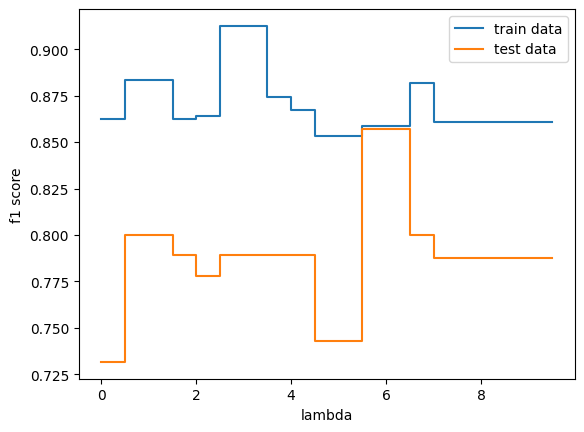

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("lambda")
ax.set_ylabel("f1 score")


ax.plot(lambda_list, train_scores,  label="train data", drawstyle="steps-post")
ax.plot(lambda_list, test_scores,  label="test data", drawstyle="steps-post")

ax.legend()
#plt.xlim(0.7)
plt.show()
plt.close('all')

- 람다값이 증가함에 따라, 출력값을 작게 만들어 특정 구간에서 과적합이 개선되는 것을 볼 수 있다.

In [ ]:
test_scores

[0.7317073170731707,
 0.8,
 0.8,
 0.7894736842105263,
 0.7777777777777778,
 0.7894736842105263,
 0.7894736842105263,
 0.7894736842105263,
 0.7894736842105263,
 0.742857142857143,
 0.742857142857143,
 0.8571428571428572,
 0.8571428571428572,
 0.7999999999999999,
 0.7878787878787878,
 0.7878787878787878,
 0.7878787878787878,
 0.7878787878787878,
 0.7878787878787878,
 0.7878787878787878]

In [ ]:
test_scores[12]

0.8571428571428572

In [ ]:
import xgboost as xgb
# 최적의 lambda값 도출
best_lambda = lambda_list[np.argmax(test_scores)]
print(f"최적의 lambda 값: {best_lambda}")

# 최적의 lambda값으로 최종 모델 학습
final_clf = xgb.XGBClassifier(use_label_encoder = False,
                        n_estimators = 500,
                        learning_rate = 0.2,
                        min_child_weight = 3,
                        colsample_bytree = 0.5,
                        max_depth = 10 , gamma = 6, reg_lambda = best_lambda, eval_metric='logloss')

final_clf.fit(X_train, Y_train, eval_set=eval_set, early_stopping_rounds=20)

# 최종 모델 평가
final_preds = final_clf.predict(X_test)
print_all_reg(Y_test, final_preds)

최적의 lambda 값: 1.5


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.60303
[1]	validation_0-logloss:0.56155
[2]	validation_0-logloss:0.51687
[3]	validation_0-logloss:0.49403
[4]	validation_0-logloss:0.46406
[5]	validation_0-logloss:0.44584
[6]	validation_0-logloss:0.43846
[7]	validation_0-logloss:0.43134
[8]	validation_0-logloss:0.41990
[9]	validation_0-logloss:0.39790
[10]	validation_0-logloss:0.39496
[11]	validation_0-logloss:0.38900
[12]	validation_0-logloss:0.38266
[13]	validation_0-logloss:0.38267
[14]	validation_0-logloss:0.38268
[15]	validation_0-logloss:0.38269
[16]	validation_0-logloss:0.38270
[17]	validation_0-logloss:0.38271
[18]	validation_0-logloss:0.38272
[19]	validation_0-logloss:0.38272
[20]	validation_0-logloss:0.38272
[21]	validation_0-logloss:0.38273
[22]	validation_0-logloss:0.38273
[23]	validation_0-logloss:0.38273
[24]	validation_0-logloss:0.38274
[25]	validation_0-logloss:0.38274
[26]	validation_0-logloss:0.38274
[27]	validation_0-logloss:0.38274
[28]	validation_0-logloss:0.38274
[29]	validation_0-loglos

In [ ]:
from xgboost import plot_importance
import seaborn as sns

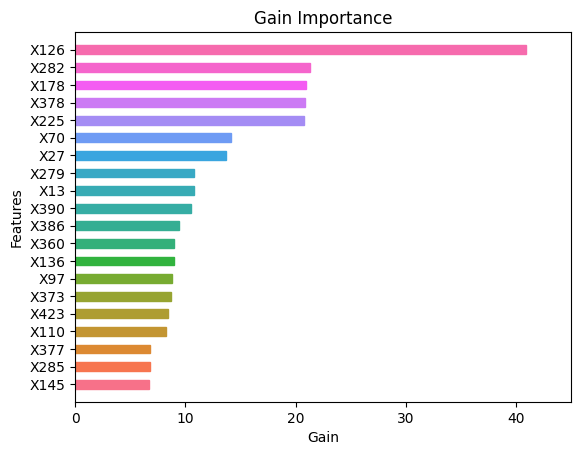

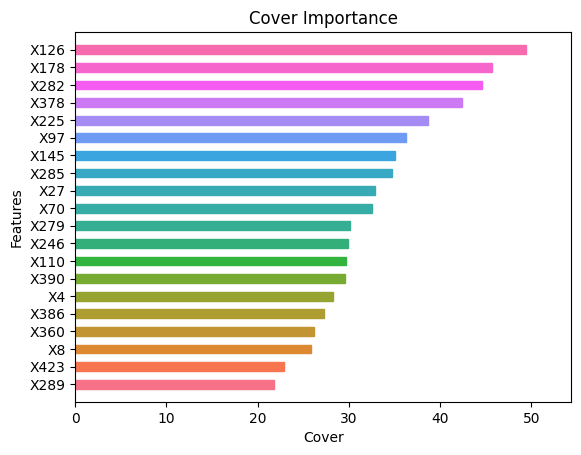

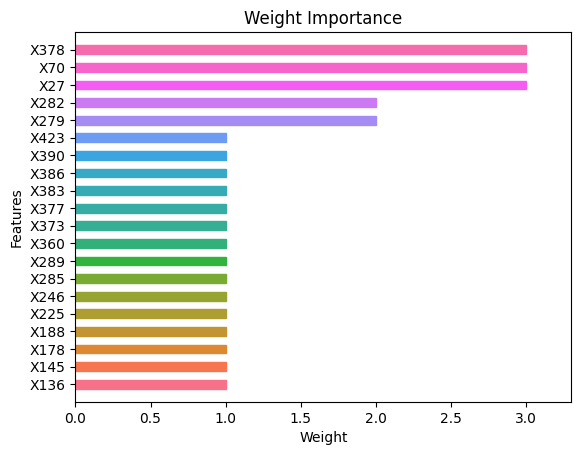

In [ ]:
# 변수 중요도 시각화 (gain)
ax = plot_importance(final_clf, importance_type='gain', max_num_features=20, height=0.5, xlabel='Gain', title='Gain Importance', show_values=False, grid=False)
plt.gca().set_facecolor('white')  # 배경색을 흰색으로 설정

# Seaborn palette 적용
palette = sns.color_palette("husl", 20)

for bar, color in zip(ax.patches, palette):
    bar.set_color(color)

plt.show()

# 변수 중요도 시각화 (cover)
ax = plot_importance(final_clf, importance_type='cover', max_num_features=20, height=0.5, xlabel='Cover', title='Cover Importance', show_values=False, grid=False)
plt.gca().set_facecolor('white')  # 배경색을 흰색으로 설정


for bar, color in zip(ax.patches, palette):
    bar.set_color(color)

plt.show()

# 변수 중요도 시각화 (weight)
ax = plot_importance(final_clf, importance_type='weight', max_num_features=20, height=0.5, xlabel='Weight', title='Weight Importance', show_values=False, grid=False)
plt.gca().set_facecolor('white')  # 배경색을 흰색으로 설정

for bar, color in zip(ax.patches, palette):
    bar.set_color(color)

plt.show()